# Demo on training of deep convolutional neural nets for spectroscopic data using Weight Sharing

This demo show how to train deep convolutional neural nets using Weight Share. The demo is based on the paper **Deep learning for Chemometric and non-translational data** by Larsen, J. S. and Clemmensen, L. (2019). The main idea is that a convolution between an input signal $x$ and a filter $\theta$ is invariant to the length of the input signal, $p$. This mean that the same filter can be used in a convolution of another input signal, $x^*$, of length $p^*$.

\begin{align}
    y_i &= \sum_{j=0}^{2h} x_{i+h-j} \theta_{j+1},\qquad i\in [1,p] \\
    y_i^* &= \sum_{j=0}^{2h} x_{i+h-j}^* \theta_{j+1},\qquad i\in [1,p^*]
\end{align}

In this way convolutional neural networks can be trained from multiple data sets with different input sizes. The architecture is illustrated below

![Illustration of the Weight Sharing strategy](imgs/CNN_arch.png)


## Data
We will demonstrate the usage of Weight Sharing using a medium sized and a small data set. The strategy can also be used to train on two large data sets simultaneously. However, the highest gain is achieved when using a small data set in combination with a larger one, as the small data set cannot be used to train a deep CNN on its own.

As the small data set we will use the SWRI data set. The data set is developed by the Southwest Reasearch Institute (SWRI) in order to evaluate diesel fuels in the battle fields. The data set contain 784 samples with 7 different properties. However, not all properties has been measured for all samples. For this reason only a subset of the samples are being used. We will try to predict the Total aromatics (mass %) and use the RMSE as cost function. As the data set is not divided into training, validation and test, we will do this in a random manner. The data set will be fetched at https://eigenvector.com/resources/data-sets/

As the large data set we will use the Chimiometrie 2019 challenge data set. The data contain 6915 samples for training and 600 samples for test, however as no target values are available for the test data, we will not utilize these. The target consist of three values: 1) Soy oil 2) Lucerne 3) Barley. All three targets are in w/w %. As this is a multiobjective task, we will use the original cost function for the challenge:

\begin{equation}
 WRMSE = \frac{1}{3}\left(\frac{RMSE_{Soy oil}}{\hat{y}_{Soy oil}} + \frac{RMSE_{Lucerne}}{\hat{y}_{Lucerne}} + \frac{RMSE_{Barley}}{\hat{y}_{Barley}}  \right)
\end{equation}

The data set will be fetched at https://chemom2019.sciencesconf.org/resource/page/id/13


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from weight_share.data import get_chimiometrie_2019_data, get_SWRI_data, dataaugment
from weight_share.training import train_weight_share, train_cnn, train_transfer
from weight_share.build_graphs import restore_predictor,restore_cnn_predictor
from weight_share.misc import read_losses
from sklearn.model_selection import train_test_split




## Download data and visualize
First we download the data and visualize it.
Note that the Chimiometrie 2019 data set has 550 input variables while the SWRI data set has 401 input variables. This is not an issue when using Weight Sharing as the convolution operation doesn't care about the length of the input signal.


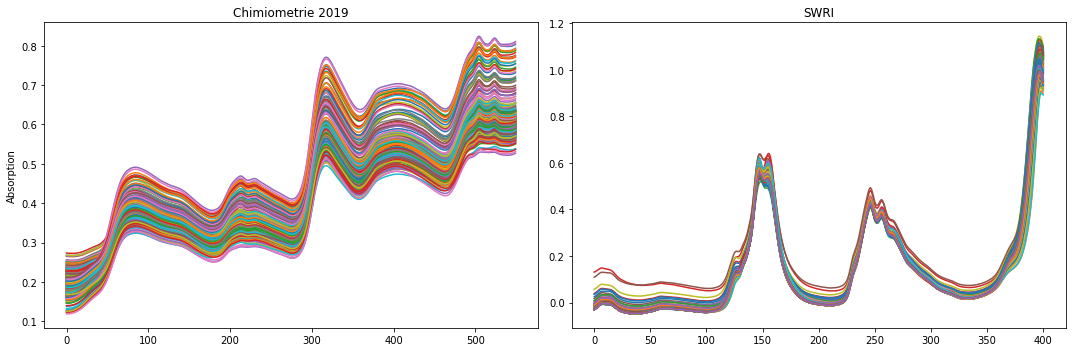

In [2]:
X_2019,Y_2019,XTest_2019 = get_chimiometrie_2019_data()
X_SWRI_all,Y_SWRI_all = get_SWRI_data()
f,(ax1,ax2) = plt.subplots(1,2,figsize = (15,5))
ax1.plot(X_2019[:500].T)
ax2.plot(X_SWRI_all.T)

ax1.set_title("Chimiometrie 2019")
ax1.set_ylabel("Absorption")
ax2.set_title("SWRI")
f.tight_layout()

## Data split and augmentation
We subsample the SWRI data set into 50-25-25 % for training, validation and test. The Chimiometrie 2019 data set we subsample into 70-30% for training and validation. We are upscaling the training and validation sets x10 by artificially adding scatter in the form of baseline shift, trending and multiplicative effects. Furthermore, as there are many zeros in the Chimiometrie 2019 data set, we add normally distributed noise to these entries as recommended by the data provider.

For spectroscopic data it is often necessary to pre-process the data in order to remove scattering. However, as shown in **Modern practical convolutional neural networks for multivariate regression: Applications to NIR calibration** by Cui, C. and Fearn, T. (2018) convolutional neural nets are able to learn the necessary pre-processing automatically.

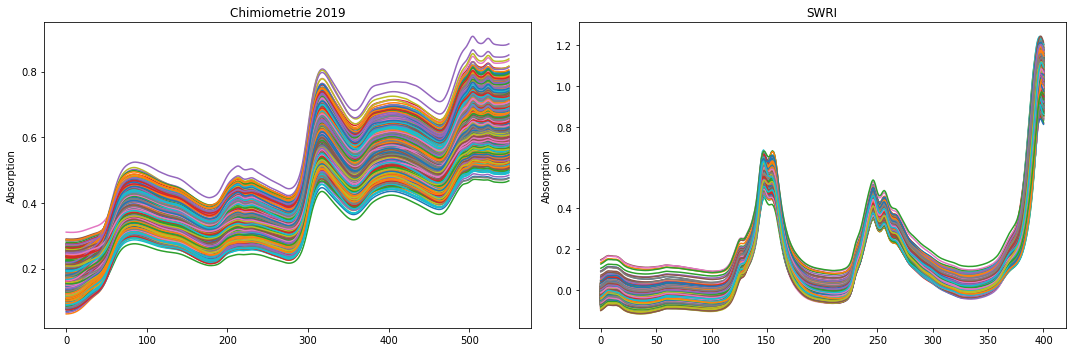

In [3]:
scatter_level_train, scatter_level_val = 0.1,0.1
nAugmentTrain, nAugmentVal = 10,10

np.random.seed(1234)
idxTrain,idxVal,idxTest = np.split(np.random.choice(X_SWRI_all.shape[0],size=X_SWRI_all.shape[0],replace=False), [int(.5*X_SWRI_all.shape[0]), int(.75*X_SWRI_all.shape[0])])

XTrain_small = X_SWRI_all[idxTrain]
YTrain_small = Y_SWRI_all[idxTrain]
XVal_small = X_SWRI_all[idxVal]
YVal_small = Y_SWRI_all[idxVal]
XTest_small = X_SWRI_all[idxTest]
YTest_small = Y_SWRI_all[idxTest]

XTrain_2019,XVal_2019,YTrain_2019,YVal_2019 = train_test_split(X_2019,Y_2019,test_size=.3)
muX_small = XTrain_small.mean()
sigmaX_small = XTrain_small.std()
    
muX_2019 = XTrain_2019.mean()
sigmaX_2019 = XTrain_2019.std()

XTrain_small,YTrain_small = dataaugment(XTrain_small,YTrain_small,
                                      do_shuffle=True, 
                                      nAugment=nAugmentTrain,
                                      muX=muX_small,
                                      sigmaX=sigmaX_small,
                                      betashift=scatter_level_train, 
                                      slopeshift=scatter_level_train,
                                      multishift=scatter_level_train)
    
XTrain_2019,YTrain_2019 = dataaugment(XTrain_2019,YTrain_2019,
                                      do_shuffle=True, 
                                      nAugment=nAugmentTrain,
                                      muX=muX_2019,
                                      sigmaX=sigmaX_2019,
                                      betashift=scatter_level_train, 
                                      slopeshift=scatter_level_train,
                                      multishift=scatter_level_train)


XVal_small,YVal_small = dataaugment(XVal_small,YVal_small,
                                  do_shuffle=True,
                                  muX=muX_small,
                                  sigmaX=sigmaX_small,
                                  nAugment=nAugmentVal,
                                  betashift=scatter_level_val, 
                                  slopeshift=scatter_level_val,
                                  multishift=scatter_level_val)

XVal_2019,YVal_2019 = dataaugment(XVal_2019,YVal_2019,
                                  do_shuffle=True,
                                  muX=muX_2019,
                                  sigmaX=sigmaX_2019,
                                  nAugment=nAugmentVal,
                                  betashift=scatter_level_val, 
                                  slopeshift=scatter_level_val,
                                  multishift=scatter_level_val)

# as there are many zeros in the Chimiometrie 2019 references, we add noise to these
for i in range(3):
    idx = np.where(YTrain_2019[:,i]==0)[0]
    YTrain_2019[idx,i] = np.random.normal(0,scale=1e-2,size=idx.shape)

for i in range(3):
    idx = np.where(YVal_2019[:,i]==0)[0]
    YVal_2019[idx,i] = np.random.normal(0,scale=1e-2,size=idx.shape)
    
weights_2019 = [1/value.astype(np.float32) for value in YTrain_2019.mean(axis=0)]

XTrain_small = np.expand_dims(XTrain_small,axis=-1)
XVal_small = np.expand_dims(XVal_small,axis=-1)
XTrain_2019 = np.expand_dims(XTrain_2019,axis=-1)
XVal_2019 = np.expand_dims(XVal_2019,axis=-1)


f,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(XTrain_2019[:2000,:,0].T)
ax[1].plot(XTrain_small[:,:,0].T)

ax[0].set_title("Chimiometrie 2019")
ax[0].set_ylabel("Absorption")
ax[1].set_title("SWRI")
ax[1].set_ylabel("Absorption")
f.tight_layout()

## Training
When training the CNN we use an exponential decayed estimate of the parameters for validation instead of the raw parameters. Furthermore, we use the checkmate package for storing the best model at *save_path*. As a model selection critieria we are using sum of the two cost functions, i.e. RMSE + WRMSE. This is done in order to avoid overfitting of the smaller validation set.

We provide a pre-trained net trained for 50000 updates stored at ./saved_sessions.

In [4]:
train_new_predictor = False
save_path = "./saved_sessions/Weight_share"
if train_new_predictor:
    predictor = train_weight_shareweight_share(XTrain_small, YTrain_small, XTrain_2019,YTrain_2019,
                                            XVal_small, YVal_small, XVal_2019,YVal_2019,
                                            save_path=save_path,
                                            batch_size=128, keep_prob=[.95]*3,  
                                            n_updates=50_000,
                                            LOG_PERIOD=250,
                                            patience_factor=10,weights_2019=weights_2019, ema_decay=0.99, 
                                            padding="SAME",learning_rate=1e-3, name='CNN_weight_sharing', 
                                            name_small="SWRI",verbose=False)
    
else:
    predictor = restore_predictor(save_path, dims_small=XTrain_small.shape[1],dims_2019=XTrain_2019.shape[1],name="CNN_weight_sharing",
                                  net="SWRI",verbose=False,padding="SAME")

INFO:tensorflow:Restoring parameters from ./saved_sessions/Weight_share\best.ckpt-40250


## Performing transfer learning
The Weight Share strategy can also be used for transfer learning, if the large data set isn't available, but a pre-trained network is. 
In this case the large data set is available, and a deep CNN is trained on this. Afterwards the weights of the convolutional layers are transfered to a new deep CNN, which is trained on the SWRI data set.

We provide both a pre-trained net and two transferred nets - one trained for 5,000 iterations and one trained for 10,000 iterations.

In [5]:
save_path_2019 = "./saved_sessions/Chim_2019"
save_path_transfer = "./saved_sessions/transfer_10000"
#save_path_transfer = "./saved_sessions/transfer_5000"
#train_new_predictor_2019 = True
train_new_predictor_2019 = False
#train_net_predictor_transfer = True
train_net_predictor_transfer = False
if train_new_predictor_2019:
    train_cnn(XTrain_2019,YTrain_2019,XVal_2019,YVal_2019,
              save_path=save_path_2019,
              batch_size=128, 
              keep_prob=[.95]*3, 
              n_updates=50_000, 
              LOG_PERIOD=250,
#              n_updates=100, 
#              LOG_PERIOD=5,
              patience_factor=5, weights=weights_2019, ema_decay=0.99, 
              padding="SAME", learning_rate=1e-3, name='CNN_Chim_2019', 
              verbose=False,return_predictor=False)
    
elif train_net_predictor_transfer:
    predictor_transfer = train_transfer(XTrain_small,YTrain_small,XVal_small,YVal_small,
                                        restore_path=save_path_2019,
                                        save_path=save_path_transfer,
                                        batch_size=128,
                                        keep_prob=[.95]*3,
                                        n_updates=5_000,
                                        LOG_PERIOD=250,
#                                        n_updates=100,
#                                        LOG_PERIOD=5,
                                        patience_factor=50,
                                        ema_decay=0.99, 
                                        padding="SAME", learning_rate=1e-3, 
                                        name_large='CNN_Chim_2019', 
                                        name_small="SWRI",
                                        verbose=False,return_predictor=True)
else:
    predictor_transfer = restore_cnn_predictor(save_path_transfer, dims=XTrain_small.shape[1], name="CNN_SWRI_NIR",net="SWRI",
                                               verbose=False,padding="SAME",large_graph=False)

INFO:tensorflow:Restoring parameters from ./saved_sessions/transfer_10000\best.ckpt-8000


## Training inspection
Besides returning and storing a predictor class, the *train_network* function also stores the training history in the *save_path* directory.

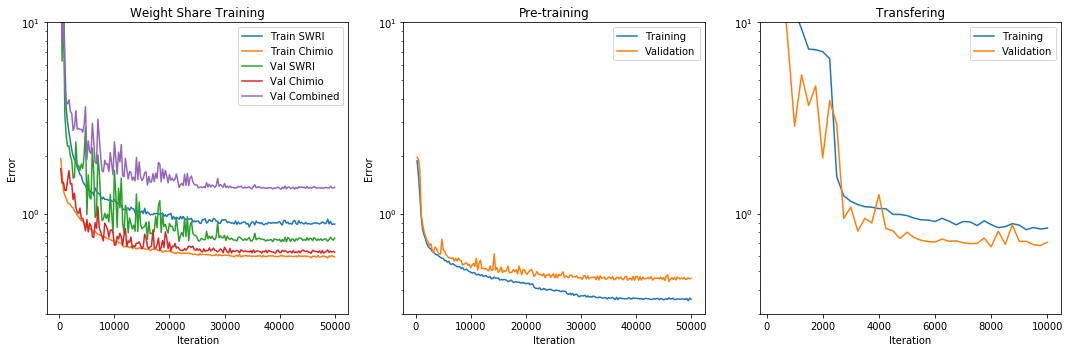

In [6]:
LOSSES_TRAIN_small,LOSSES_TRAIN_WS_2019,LOSSES_VAL = read_losses(save_path)
n_iter = len(LOSSES_TRAIN_small['CNN_weight_sharing/cost/cost']) 
iters = np.arange(250,n_iter*250+1,250)

f = plt.figure(figsize=(15,5))
ax1 = plt.subplot(131)
ax1.semilogy(iters,LOSSES_TRAIN_small['CNN_weight_sharing/cost/cost'],label="Train SWRI")
ax1.plot(iters,LOSSES_TRAIN_WS_2019['CNN_weight_sharing/cost/cost'],label="Train Chimio")
ax1.plot(iters,LOSSES_VAL['CNN_weight_sharing/cost/small/RMSE'],label="Val SWRI")
ax1.plot(iters,LOSSES_VAL['CNN_weight_sharing/cost/2019/WRMSE'],label="Val Chimio")
ax1.plot(iters,LOSSES_VAL['CNN_weight_sharing/cost/cost'],label="Val Combined")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Error")
ax1.set_title("Weight Share Training")
ax1.legend()
ax1.set_ylim(.3,10)

LOSSES_TRAIN_2019,LOSSES_VAL_2019 = read_losses(save_path_2019)
LOSSES_TRAIN_Transfer,LOSSES_VAL_Transfer= read_losses(save_path_transfer)
n_iter = len(LOSSES_TRAIN_2019['CNN_Chim_2019/cost/cost']) 
n_iter_transfer = len(LOSSES_TRAIN_Transfer['CNN_SWRI_NIR/cost/cost'])
iters = np.arange(250,n_iter*250+1,250)
iters_transfer = np.arange(250,250*n_iter_transfer+1,250)
ax2 = plt.subplot(132,sharey=ax1)
ax2.semilogy(iters,LOSSES_TRAIN_2019['CNN_Chim_2019/cost/cost'],label="Training")
ax2.plot(iters,LOSSES_VAL_2019['CNN_Chim_2019/cost/MT/cost'],label="Validation")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Error")
ax2.legend()
ax2.set_title("Pre-training")

ax3 = plt.subplot(133,sharey=ax1)
ax3.semilogy(iters_transfer,LOSSES_TRAIN_Transfer['CNN_SWRI_NIR/cost/cost'],label="Training")
ax3.plot(iters_transfer,LOSSES_VAL_Transfer['CNN_SWRI_NIR/cost/MT/cost'],label="Validation")
ax3.set_xlabel("Iteration")
ax3.legend()
ax3.set_title("Transfering")

f.tight_layout()



## Evaluation on the test set and comparison to Transfer learning
The nets trained using Weight Share are put into a predictor class with the methods *predict_small* and *predict_2019* used to predict new data from the two data sets. While the net trained using Transfer learning is put into cnn_predictor class with the method *predict*.

As we are interested in knowing how well the trained nets perform on the smaller of the two data sets, we predict the test set from the SWRI data set.

In the two plots to the left a scatter plot and boxplot are shown for the Weight Share strategy, while the same plots are shown for Transfer learning to the right. 

It is clear, both from the plots and the reported RMSE, that the Transfer learning strategy has slightly overfitted both the training and validation set, while the Weight Share strategy has slightly overfitted the training data but not the validation data. Note, that the Net trained using Transfer learning for 5,000 has not yet overfit the val data, but is still achieving and RMSE on the test data aroung 0.8.

Weight Share:
RMSE Train: 0.491
RMSE Val: 0.686
RMSE Test: 0.685

Transfer Learning
RMSE Train: 0.476
RMSE Val: 0.646
RMSE Test: 0.860


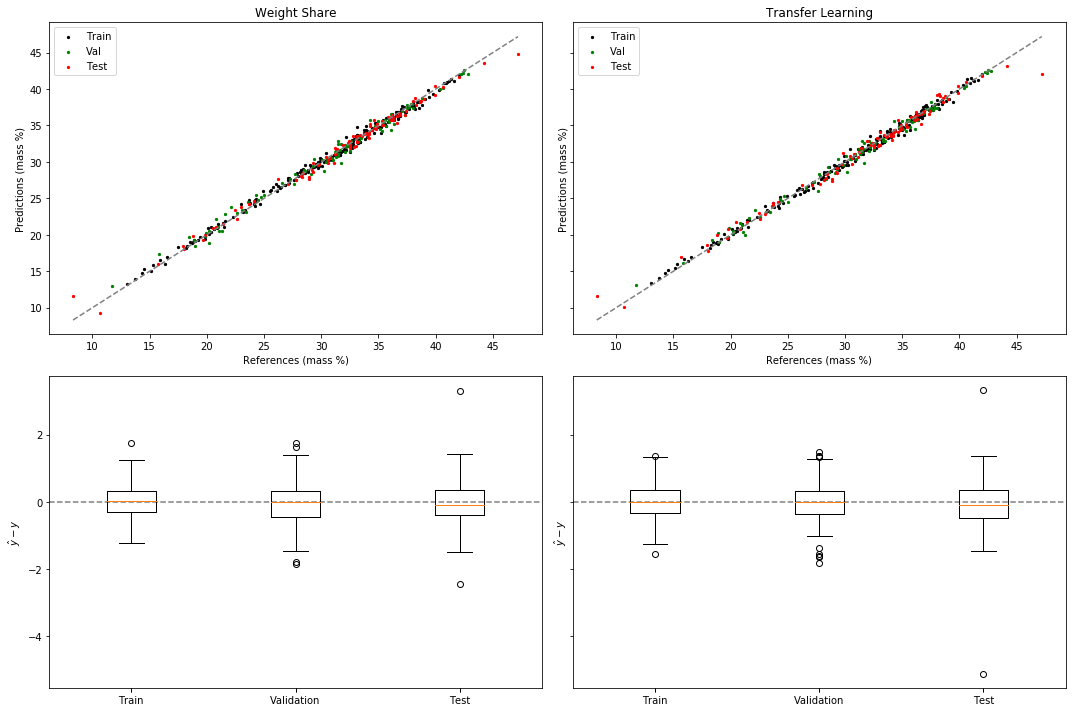

In [7]:
preds_small_train = predictor.predict_small(X_SWRI_all[idxTrain])
preds_small_val = predictor.predict_small(X_SWRI_all[idxVal])
preds_small_test = predictor.predict_small(XTest_small)

res_small_train = preds_small_train-Y_SWRI_all[idxTrain]
res_small_val = preds_small_val-Y_SWRI_all[idxVal]
res_small_test = preds_small_test-YTest_small

rmse_small_train = (res_small_train**2).mean()**(1/2)
rmse_small_val = (res_small_val**2).mean()**(1/2)
rmse_small_test = (res_small_test**2).mean()**(1/2)

f,ax=plt.subplots(2,2,figsize=(15,10),sharex="row",sharey="row")
ax[0,0].plot([YTest_small.min(),YTest_small.max()],[YTest_small.min(),YTest_small.max()],c="gray",ls="--")
ax[0,0].scatter(Y_SWRI_all[idxTrain],preds_small_train,s=5,c="black",label="Train")
ax[0,0].scatter(Y_SWRI_all[idxVal],preds_small_val,s=5,c="green",label="Val")
ax[0,0].scatter(YTest_small,preds_small_test,s=5,c="red",label="Test")
ax[0,0].legend()
ax[0,0].set_xlabel("References (mass %)")
ax[0,0].set_ylabel("Predictions (mass %)")
ax[0,0].set_title("Weight Share")

ax[1,0].axhline(0,c="gray",ls="--",zorder=0)
ax[1,0].boxplot([res_small_train,res_small_val,res_small_test],zorder=1)
ax[1,0].set_xticklabels(["Train","Validation","Test"],zorder=1)
ax[1,0].set_ylabel(r"$\hat{y}-y$",zorder=1)

print("Weight Share:")
print(f"RMSE Train: {rmse_small_train:.3f}")
print(f"RMSE Val: {rmse_small_val:.3f}")
print(f"RMSE Test: {rmse_small_test:.3f}")
print()

# Predict using transfer learning
preds_transfer_train = predictor_transfer.predict(X_SWRI_all[idxTrain])
preds_transfer_val = predictor_transfer.predict(X_SWRI_all[idxVal])
preds_transfer_test = predictor_transfer.predict(XTest_small)

res_transfer_train = preds_transfer_train-Y_SWRI_all[idxTrain]
res_transfer_val = preds_transfer_val-Y_SWRI_all[idxVal]
res_transfer_test = preds_transfer_test-YTest_small

rmse_transfer_train = (res_transfer_train**2).mean()**(1/2)
rmse_transfer_val = (res_transfer_val**2).mean()**(1/2)
rmse_transfer_test = (res_transfer_test**2).mean()**(1/2)

#f,ax=plt.subplots(1,2,figsize=(10,5))
ax[0,1].plot([YTest_small.min(),YTest_small.max()],[YTest_small.min(),YTest_small.max()],c="gray",ls="--")
ax[0,1].scatter(Y_SWRI_all[idxTrain],preds_transfer_train,s=5,c="black",label="Train")
ax[0,1].scatter(Y_SWRI_all[idxVal],preds_transfer_val,s=5,c="green",label="Val")
ax[0,1].scatter(YTest_small,preds_transfer_test,s=5,c="red",label="Test")
ax[0,1].legend()
ax[0,1].set_xlabel("References (mass %)")
ax[0,1].set_ylabel("Predictions (mass %)")
ax[0,1].set_title("Transfer Learning")

ax[1,1].axhline(0,c="gray",ls="--",zorder=0)
ax[1,1].boxplot([res_transfer_train,res_transfer_val,res_transfer_test],zorder=1)
ax[1,1].set_xticklabels(["Train","Validation","Test"],zorder=1)
ax[1,1].set_ylabel(r"$\hat{y}-y$",zorder=1)

f.tight_layout()
print("Transfer Learning")
print(f"RMSE Train: {rmse_transfer_train:.3f}")
print(f"RMSE Val: {rmse_transfer_val:.3f}")
print(f"RMSE Test: {rmse_transfer_test:.3f}")